# Cell Ranger의 기본 파이프라인 

1. **FASTQ parsing**
* R1: Cell Barcode + UMI
* R2: cDNA read (actual transcript sequence)
* whitelist된 cell barcode만 유효한 셀로 취급.

2. **Alignment**
* R2를 reference genome에 align (STAR aligner 기반).
* 유효한 read만 BAM에 기록.

3. **Correction / QC**
* cell barcode는 whitelist 기반으로 nearest-neighbor correction.
* UMI는 sequencing error 교정 (예: 1-bp mismatch clustering).
* low-quality cells (low # of UMIs, high MT%) 필터링.

4. **Counting**
* (cell barcode, UMI, gene) 조합을 unique하게 세어 gene expression matrix 생성.

In [1]:
# 1. 필요한 라이브러리 불러오기
import gzip
import collections
import tables
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import csr_matrix
import h5py
import matplotlib.pyplot as plt

### 사용 데이터: 1k PBMCs from a Healthy Donor (v3 chemistry)
* 10k는 fastq파일이 무겁다보니 빠르게 hands-on 위해 비교적 가벼운 1k 선택
* Available at 10x Genomics: mannually download from [here](https://www.10xgenomics.com/datasets/1-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0)

## 1. FASTQ Parsing 

* `R1`: Cell Barcode + UMI (보통 28bp = 16bp barcode + 12bp UMI)

* `R2`: cDNA (transcript sequence), 즉 실제 유전자 서열 -> 유전자 alignment / transcript 정보

* `L001`, `L002` … : sequencing lane 번호 (하나의 시퀀싱 런이 여러 lane으로 쪼개질 수 있음)

* `_001` : read chunk 번호 (한 lane에서 파일을 여러 개로 쪼개 저장했을 때)

* `I1`/`I2`: sample index → multiplexed sequencing에서 어떤 sample인지 구분하는데 사용, PBMC 단일 샘플이면 분석에 필요 없음

In [2]:
import os

fastq_folder = "data/pbmc_1k_v3_fastqs"

fastq_files = sorted([f for f in os.listdir(fastq_folder) if f.endswith(".fastq.gz")])
print("FASTQ R1 파일 목록:")
for f in fastq_files:
    print(f)

# 각 파일에서 첫 4개의 read 살펴보기 (FASTQ 구조 확인)
for f in fastq_files:
    print(f"\n============ {f} ============")
    with gzip.open(os.path.join(fastq_folder, f), "rt") as fq:
        for i in range(6):
            header = fq.readline().strip()
            seq = fq.readline().strip()
            plus = fq.readline().strip()
            qual = fq.readline().strip()
            print(header)
            print(seq)
            print(plus)
            print(qual)
    print("=============================")

FASTQ R1 파일 목록:
pbmc_1k_v3_S1_L001_I1_001.fastq.gz
pbmc_1k_v3_S1_L001_R1_001.fastq.gz
pbmc_1k_v3_S1_L001_R2_001.fastq.gz
pbmc_1k_v3_S1_L002_I1_001.fastq.gz
pbmc_1k_v3_S1_L002_R1_001.fastq.gz
pbmc_1k_v3_S1_L002_R2_001.fastq.gz

============ pbmc_1k_v3_S1_L001_I1_001.fastq.gz ============
@A00228:279:HFWFVDMXX:1:1101:8486:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:10782:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:12626:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:14452:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:24071:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF
@A00228:279:HFWFVDMXX:1:1101:32461:1000 1:N:0:NCATTACT
NCATTACT
+
#FFFFFFF

============ pbmc_1k_v3_S1_L001_R1_001.fastq.gz ============
@A00228:279:HFWFVDMXX:1:1101:8486:1000 1:N:0:NCATTACT
NGTGATTAGCTGTACTCGTATGTAAGGT
+
#FFFFFFFFFFFFFFFFFFFFFFFFFFF
@A00228:279:HFWFVDMXX:1:1101:10782:1000 1:N:0:NCATTACT
NTCATGAAGTTTGGCTAGTTATGTTCAT
+
#

In [3]:
def read_all_r1_fastq(barcode_umi_folder, max_reads_per_file=None):
    """
    폴더 안 모든 R1 FASTQ 파일을 읽어서 (cell barcode, UMI) Counter 생성
    - R1 파일만 자동 선택
    - max_reads_per_file: 각 파일에서 최대 읽을 read 수 (샘플링용)
    """
    barcode_umi_counts = collections.Counter()
    
    # R1 FASTQ만 골라서 정렬
    fastq_files = sorted([f for f in os.listdir(barcode_umi_folder) 
                          if f.endswith(".fastq.gz") and "_R1_" in f])
    
    if not fastq_files:
        print("폴더 안에 R1 FASTQ 파일이 없습니다!")
        return barcode_umi_counts
    
    print(f"Found {len(fastq_files)} R1 FASTQ files.")
    
    for f in fastq_files:
        file_path = os.path.join(barcode_umi_folder, f)
        print(f"Processing {f} ...")
        with gzip.open(file_path, "rt") as fq:
            count = 0
            while True:
                header = fq.readline().strip()
                if not header:
                    break
                seq = fq.readline().strip()
                fq.readline()  # +
                fq.readline()  # quality
                
                # 10x v3 chemistry 기준: 16bp cell barcode + 12bp UMI
                cell_barcode = seq[:16]
                umi = seq[16:28]
                barcode_umi_counts[(cell_barcode, umi)] += 1
                
                count += 1
                if max_reads_per_file and count >= max_reads_per_file:
                    break
    
    print(f"총 unique (cell barcode, UMI) 조합: {len(barcode_umi_counts)}")
    return barcode_umi_counts

In [4]:
barcode_umi_counts = read_all_r1_fastq(fastq_folder, max_reads_per_file=50000)

Found 2 R1 FASTQ files.
Processing pbmc_1k_v3_S1_L001_R1_001.fastq.gz ...
Processing pbmc_1k_v3_S1_L002_R1_001.fastq.gz ...
총 unique (cell barcode, UMI) 조합: 91732


In [5]:
def barcode_umi_summary(barcode_umi_counts, top_n):
    """
    barcode+UMI Counter를 DataFrame으로 변환하고 요약
    """
    # Counter -> DataFrame
    df = pd.DataFrame(
        list(barcode_umi_counts.items()),
        columns=["cell_barcode_UMI", "count"]
    )
    
    # cell barcode, UMI 분리
    df["cell_barcode"] = df["cell_barcode_UMI"].apply(lambda x: x[0])
    df["UMI"] = df["cell_barcode_UMI"].apply(lambda x: x[1])
    
    # cell barcode 기준으로 UMI 개수 합계
    barcode_summary = df.groupby("cell_barcode")["count"].sum().reset_index()
    barcode_summary = barcode_summary.sort_values(by="count", ascending=False)
    
    print(f"총 unique cell barcode: {barcode_summary.shape[0]}")
    print(f"상위 {top_n} cell barcode:")
    display(barcode_summary.head(top_n))
    
    # histogram
    plt.figure(figsize=(6,4))
    plt.hist(barcode_summary["count"], bins=50, color='skyblue', log=True)
    plt.xlabel("UMI count per cell barcode")
    plt.ylabel("Number of cell barcodes (log scale)")
    plt.title("Distribution of UMI counts per cell barcode")
    plt.show()
    
    return df, barcode_summary

총 unique cell barcode: 10167
상위 None cell barcode:


,cell_barcode,count
3824,CGAGAAGTCAAGTTGC,453
5412,GATCACACACCCTGTT,428
4229,CTACAGACAACAAAGT,344
6488,GGTTGTATCGAAGGAC,274
3459,CCGATGGGTTCTCGCT,238
...,...,...
3742,CCTGGTAGTCGTGTTA,1
3743,CCTGTCGGTGTGCCTG,1
3744,CCTGTTGACTGGATCT,1
3745,CCTGTTGAGCTGAGCA,1


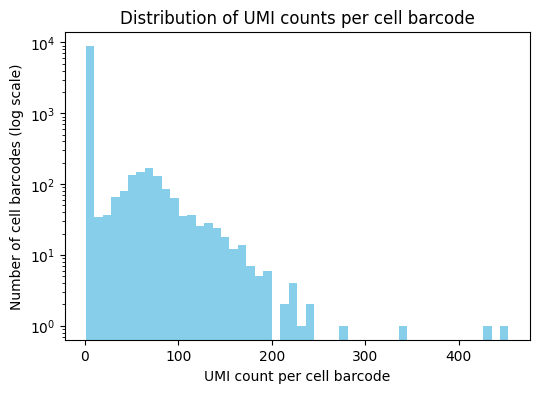

In [6]:
# barcode_umi_counts = read_all_r1_fastq(fastq_folder, max_reads_per_file=50000)
df_counts, barcode_summary = barcode_umi_summary(barcode_umi_counts, top_n=None)

In the [10x genomics](https://www.10xgenomics.com/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0) ...
* it says **1,222 cells** were detected..
* How come?!

    1. Sequencing noise
        * Illumina 에러나 PCR 에러 때문에 잘못된 barcode가 생길 수 있음.
    2. ambient RNA / background capture
        * 실제 cell이 없는 droplet에 RNA가 들어가 sequencing 될 수도 있음.
        * barcode는 나오지만 진짜 cell은 아님.
    3. barcode whitelist
        * Cell Ranger: 사전에 정의된 10x barcode whitelist를 기준으로 교정:
            * 거기 없는 barcode는 무시하거나 가까운 barcode로 교정(correction)
    4. cell calling 단계
        * Cell Ranger: barcode별 UMI 분포로 진짜 cell vs. background을 자름

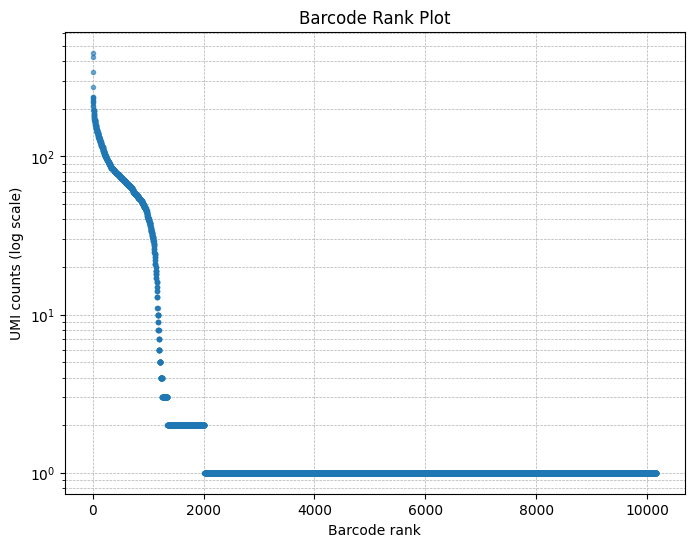

In [7]:
def plot_barcode_rank(barcode_umi_counts, top_n=None):
    """
    barcode rank plot 그리기
    - x축: rank (barcode 순위)
    - y축: UMI count (로그 스케일)
    """
    # barcode별 UMI count 합산
    barcode_counts = {}
    for (barcode, umi), c in barcode_umi_counts.items():
        barcode_counts[barcode] = barcode_counts.get(barcode, 0) + c
    
    # 내림차순 정렬
    sorted_counts = sorted(barcode_counts.values(), reverse=True)
    
    # 상위 top_n개만 표시
    sorted_counts = sorted_counts[:top_n]
    
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(sorted_counts)+1), sorted_counts, marker='.', linestyle='none', alpha=0.6)
    plt.yscale("log")
    plt.xlabel("Barcode rank")
    plt.ylabel("UMI counts (log scale)")
    plt.title("Barcode Rank Plot")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()
    
    return sorted_counts

sorted_counts = plot_barcode_rank(barcode_umi_counts, top_n=None)

In [8]:
# --------------------------------------------------------------------
#    Cell Ranger h5에서 barcodes 읽기 (robust)
# --------------------------------------------------------------------
def load_cellranger_barcodes(h5_path):
    """
    여러 10x .h5 포맷에 대응하여 barcodes 리스트를 반환 (set)
    """
    with h5py.File(h5_path, "r") as f:
        # try common locations
        arr = None
        # common new format: /matrix/barcodes
        if "matrix" in f and "barcodes" in f["matrix"]:
            arr = f["matrix"]["barcodes"][:]
        # sometimes root-level 'barcodes'
        elif "barcodes" in f:
            arr = f["barcodes"][:]
        else:
            # try to find any dataset named 'barcodes' in the file
            def find_barcodes(group):
                for k in group:
                    obj = group[k]
                    if isinstance(obj, h5py.Dataset) and k == "barcodes":
                        return obj[:]
                    elif isinstance(obj, h5py.Group):
                        res = find_barcodes(obj)
                        if res is not None:
                            return res
                return None
            arr = find_barcodes(f)
        if arr is None:
            raise RuntimeError("Could not find barcodes dataset inside the h5 file.")
        # decode bytes if needed
        barcodes = [b.decode("utf-8") if isinstance(b, (bytes, bytearray)) else str(b) for b in arr]
    return set(barcodes)

# helper: create tolerant set (add/remove '-1' suffix variants to improve matching)
def tolerant_barcode_set(barcodes):
    s = set()
    for b in barcodes:
        s.add(b)
        if b.endswith("-1"):
            s.add(b[:-2])
        else:
            s.add(b + "-1")
    return s

# --------------------------------------------------------------------
#    메인 플롯 함수: manual(top K) vs Cell Ranger 선택 비교
# --------------------------------------------------------------------
def plot_manual_vs_cellranger(barcode_umi_counts,
                              fastq_top_n=20000,
                              cellranger_h5_path=None,
                              manual_topk=1000,
                              expect_cells=1000,
                              show_top_n_on_x=20000,
                              figsize=(10,6)
                             ):
    """
    - barcode_umi_counts: Counter((barcode, umi) -> count)
    - cellranger_h5_path: path to .h5 (Cell Ranger matrix) to get selected barcodes
    - manual_topk: how many top barcodes you 'manually' call as cells (e.g., 1000)
    - expect_cells: the --expect-cells used (will be drawn as vertical line)
    - show_top_n_on_x: how many ranks to plot on x axis (for speed)
    """
    # aggregate by barcode
    barcode_counts = {}
    for (cb, umi), c in barcode_umi_counts.items():
        barcode_counts[cb] = barcode_counts.get(cb, 0) + c
    total_barcodes = len(barcode_counts)
    print(f"Total unique barcodes (raw): {total_barcodes}")

    # sort descending
    sorted_items = sorted(barcode_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_barcodes = [b for b,_ in sorted_items]
    sorted_counts = [cnt for _,cnt in sorted_items]

    # restrict plotted range
    Nplot = min(show_top_n_on_x, len(sorted_counts))
    x = np.arange(1, Nplot+1)
    y = np.array(sorted_counts[:Nplot])

    # manual selection: top-K barcodes
    manual_barcodes = set(sorted_barcodes[:manual_topk])
    manual_indices = [i for i,b in enumerate(sorted_barcodes[:Nplot]) if b in manual_barcodes]
    manual_counts = [sorted_counts[i] for i in manual_indices]

    # load Cell Ranger selected barcodes (if provided)
    cr_indices = []
    cr_counts = []
    cr_barcodes = set()
    if cellranger_h5_path:
        try:
            cr_barcodes = load_cellranger_barcodes(cellranger_h5_path)
            cr_barcodes = tolerant_barcode_set(cr_barcodes)  # tolerant matching
            # find their indices among sorted_barcodes (within plotted range)
            cr_indices = [i for i,b in enumerate(sorted_barcodes[:Nplot]) if b in cr_barcodes]
            cr_counts = [sorted_counts[i] for i in cr_indices]
        except Exception as e:
            print("Warning: couldn't load cellranger barcodes:", e)
            cr_barcodes = set()

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(x, y, marker='.', linestyle='none', alpha=0.4, label='All barcodes (manual raw)')
    if manual_indices:
        plt.scatter([i+1 for i in manual_indices], manual_counts, s=20, marker='o', facecolors='none', edgecolors='green', label=f'Manual top-{manual_topk}')
    if cr_indices:
        plt.scatter([i+1 for i in cr_indices], cr_counts, s=15, color='red', label=f'Cell Ranger selected ({len(cr_barcodes)} in h5)')

    # vertical lines: expect_cells and cellranger detected number
    plt.axvline(x=expect_cells, color='gray', linestyle='--', linewidth=1, label=f'--expect-cells={expect_cells}')
    if cellranger_h5_path and len(cr_barcodes) > 0:
        plt.axvline(x=len(cr_barcodes), color='red', linestyle=':', linewidth=1, label=f'CR detected = {len(cr_barcodes)}')

    plt.yscale('log')
    plt.xlabel('Barcode rank')
    plt.ylabel('UMI counts (log scale)')
    plt.title('Barcode rank: Manual top-K vs Cell Ranger selection')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.4)
    plt.show()

    # intersection stats
    if cellranger_h5_path:
        manual_set = set(sorted_barcodes[:manual_topk])
        # note: cr_barcodes is tolerant set; but we want original cr list vs manual
        intersection = manual_set.intersection(cr_barcodes)
        print(f"Manual top-{manual_topk}: {len(manual_set)} barcodes")
        print(f"Cell Ranger barcodes (h5): {len(cr_barcodes)} (tolerant count)")
        print(f"Intersection (manual ∩ CR): {len(intersection)} barcodes")
    else:
        print(f"Manual top-{manual_topk}: {len(manual_barcodes)} barcodes (no CR h5 provided)")

    return {
        "sorted_barcodes": sorted_barcodes,
        "sorted_counts": sorted_counts,
        "manual_indices": manual_indices,
        "cr_indices": cr_indices,
        "cr_barcodes": cr_barcodes
    }

In [ ]:
barcode_umi_counts = read_all_r1_fastq(fastq_folder, max_reads_per_file=None)

# 2) .h5 경로 지정 (Cell Ranger output)
cellranger_h5 = "data/pbmc_1k_v3_raw_feature_bc_matrix.h5"  # 예시, 실제 경로로 바꾸세요

# 3) plot (manual top-K 예: 1000) 및 expect_cells=1000 표시
res = plot_manual_vs_cellranger(barcode_umi_counts,
                                show_top_n_on_x=20000,
                                cellranger_h5_path=cellranger_h5,
                                manual_topk=1000,
                                expect_cells=1000)


Found 2 R1 FASTQ files.
Processing pbmc_1k_v3_S1_L001_R1_001.fastq.gz ...
